In [1]:
from collections import defaultdict
from datetime import datetime
import dill
from itertools import permutations, combinations
import json
from operator import itemgetter
import os
import pickle
import random
import re
import time

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
sns.set(style='ticks', font_scale=1.2)
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import little_mallet_wrapper as lmw

In [2]:
data_directory_path   = '/Users/maria/Documents/data/birth-control'
output_directory_path = '/Users/maria/Documents/output/birth-control'
topics_directory_path = '/Users/maria/Documents/output/birth-control/topics-by-leann/revision-final'

In [3]:
source_topic_keys_dict = {}
source_distributions_dict = {}
source_training_dict = {}

for _source in ['reddit', 'twitter', 'webmd']:

    source_topic_keys_dict[_source] = [_line.split('\t')[2].split()[:10] for _line in open(topics_directory_path + '/' + _source + '/mallet.topic_keys.35', 'r') if _line.strip()]
    source_distributions_dict[_source] = [_line.split('\t')[2:] for _line in open(topics_directory_path + '/' + _source + '/mallet.topic_distributions.35', 'r') if _line.strip()]
    source_training_dict[_source] = [' '.join(_line.split()[2:]) for _line in open(topics_directory_path + '/' + _source + '/training.txt', 'r') if _line.strip()]

len(source_topic_keys_dict['reddit']), len(source_distributions_dict['reddit']), len(source_training_dict['reddit']), len(source_distributions_dict['twitter']), len(source_training_dict['twitter']), len(source_distributions_dict['webmd']), len(source_training_dict['webmd'])

(35, 48000, 48000, 48000, 48000, 2640, 2640)

In [4]:
# new dictionary to better match survey paper (Nelson)

category_patterns_dict = {'breast': [r'(breast(?:s)?|boob(?:s)?) (hurt|(is|are) (sore|sensitive|tender))',
                                                 r'soreness of (breast(?:s)?|boob(?:s)?)',
                                                 r'(tender|sore|sensitive) (breast(?:s)?|boob(?:s)?)',
                                                 r'(breast(?:s)?|boob(?:s)?) pain',
                                                 r'(chest|breast(?:s)?|boob(?:s)?) grew',
                                                 r'(chest|breast(?:s)?|boob(?:s)?) got bigger'],
                        'dizziness': ['dizzy',
                                      'dizziness',
                                      'light-headed',
                                      'light headed',
                                      'lightheaded',
                                      'faint', 
                                      'pass out',
                                      'passed out'],
                        'blood pressure': ['blood pressure'],
                        'nausea': ['nausea', 
                                   'naseuous', 
                                   'sick to my stomach', 
                                   'queasy', 
                                   'vomit', 
                                   'throw up', 
                                   'puke',
                                   'puking'],
                        'skin': ['skin is clearing up', 
                                            'breaking out',
                                            'broke out',
                                            'break out',
                                            'acne', 
                                            'pimples', 
                                            'melasma'], 
                        'bleeding': ['spotting',
                                    'breakthrough bleed',
                                    'bleed nonstop',
                                    'period nonstop',
                                    'nonstop period',
                                    'heavy period',
                                    r'period(?:s)? (became|is|are) (heavy|light|irregular)',
                                    'bleed',
                                    'heavy period',
                                    'light period'], 
                        'no period': ['missed period',
                                           'missed my period'
                                           'skipped period',
                                           'skipped my period',
                                           'no period'],
                        'appetite': ['appetite',
                                     'craving',
                                     'hungry'],
                        'weight gain': [r'(gain(?:ed)?) a (couple|few) pounds', 
                                        r'(gain(?:ed)?) weight',
                                        r'(gain(?:ed)?) [a-z0-9]+ (pounds|kilograms|lb|lbs|kg|stone)'],
                        'mood': ['anxiety', 
                                         'mood', 
                                         'depression', 
                                         'depressed', 
                                         'anxious', 
                                         'anxiety',
                                         'mental health', 
                                         'panic attack', 
                                         'irritable', 
                                         'irritability',
                                         'emotional'], 
                        'libido': ['sex drive', 
                                   'sexual drive',
                                   'libido'],
                        'bloating': ['bloat',
                                     'water retention'],
                        'fatigue': ['sleepy', 
                                    'can\'t sleep', 
                                    'tired all the time', 
                                    'always feel tired', 
                                    'exhausted',
                                    'fatigue', 
                                    'always tired'], 
                        'pms': ['pms'],
                        'hair loss': ['hair loss',
                                      'hair fell',
                                      'hair thinning',
                                      'bald',
                                      'hair fall',
                                      'hair shed'],
                        'headache': ['headache', 
                                                  'head hurt',
                                                  'head ache',
                                                  'migraine'],
                        'infection': ['infection', 
                                      'uti'], # careful, need to search for token not any string containing (maybe do this for any target with fewer than X characters)
                        'heart attack': ['heart attack'],
                        'stroke': ['blood clot', 
                                    'pulmonary embolism', 
                                    'stroke'],
                        'discharge': ['discharge'],
                        'dryness': ['lubricat', 
                                    'dryness', 
                                    'wet'],
                        'cramps': ['cramp', 
                                   'period pain', 
                                   'painful period', 
                                   'pain from my period'],
                        'pain': ['painful', 
                                 'pain', 
                                 'hurt',
                                 'agony',
                                 'cramp',
                                 'throb',
                                 'stabbing',
                                 'stabbed',
                                 'ache'], # will include headache but that's ok? should we also include 'tender', 'sensitive' which will include breast sensitivity?
                        'felt strings': ['pok(ed|ing) (him|them|my boyfriend|my husband|my partner)', 
                                         r'(partner|husband|boyfriend|bf|he|they) (could feel|felt) (my|the) (strings|iud)'],
                        'general': ['side effect']}

In [5]:
source_side_effect_ids_dict = defaultdict(lambda: defaultdict(list))

for _source, _texts in source_training_dict.items():

    print(str(datetime.now()) + ' ' + _source)

    for i, _text in enumerate(_texts):

        for _side_effect, _patterns in category_patterns_dict.items():

            _match = False
            for _pattern in _patterns:
                if len(_pattern) >= 4:
                    if len(re.findall(_pattern, _text.lower())) > 0:
                        _match = True
                else:
                    if _pattern in _text.lower().replace('.', ' ').replace('!', ' ').replace('?', ' ' ).replace(',', ' ').replace(';', ' ').split():
                        _match = True
            if _match:
                source_side_effect_ids_dict[_source][_side_effect].append(i)

2022-09-15 14:52:56.217142 reddit
2022-09-15 14:53:03.067791 twitter
2022-09-15 14:53:07.576245 webmd


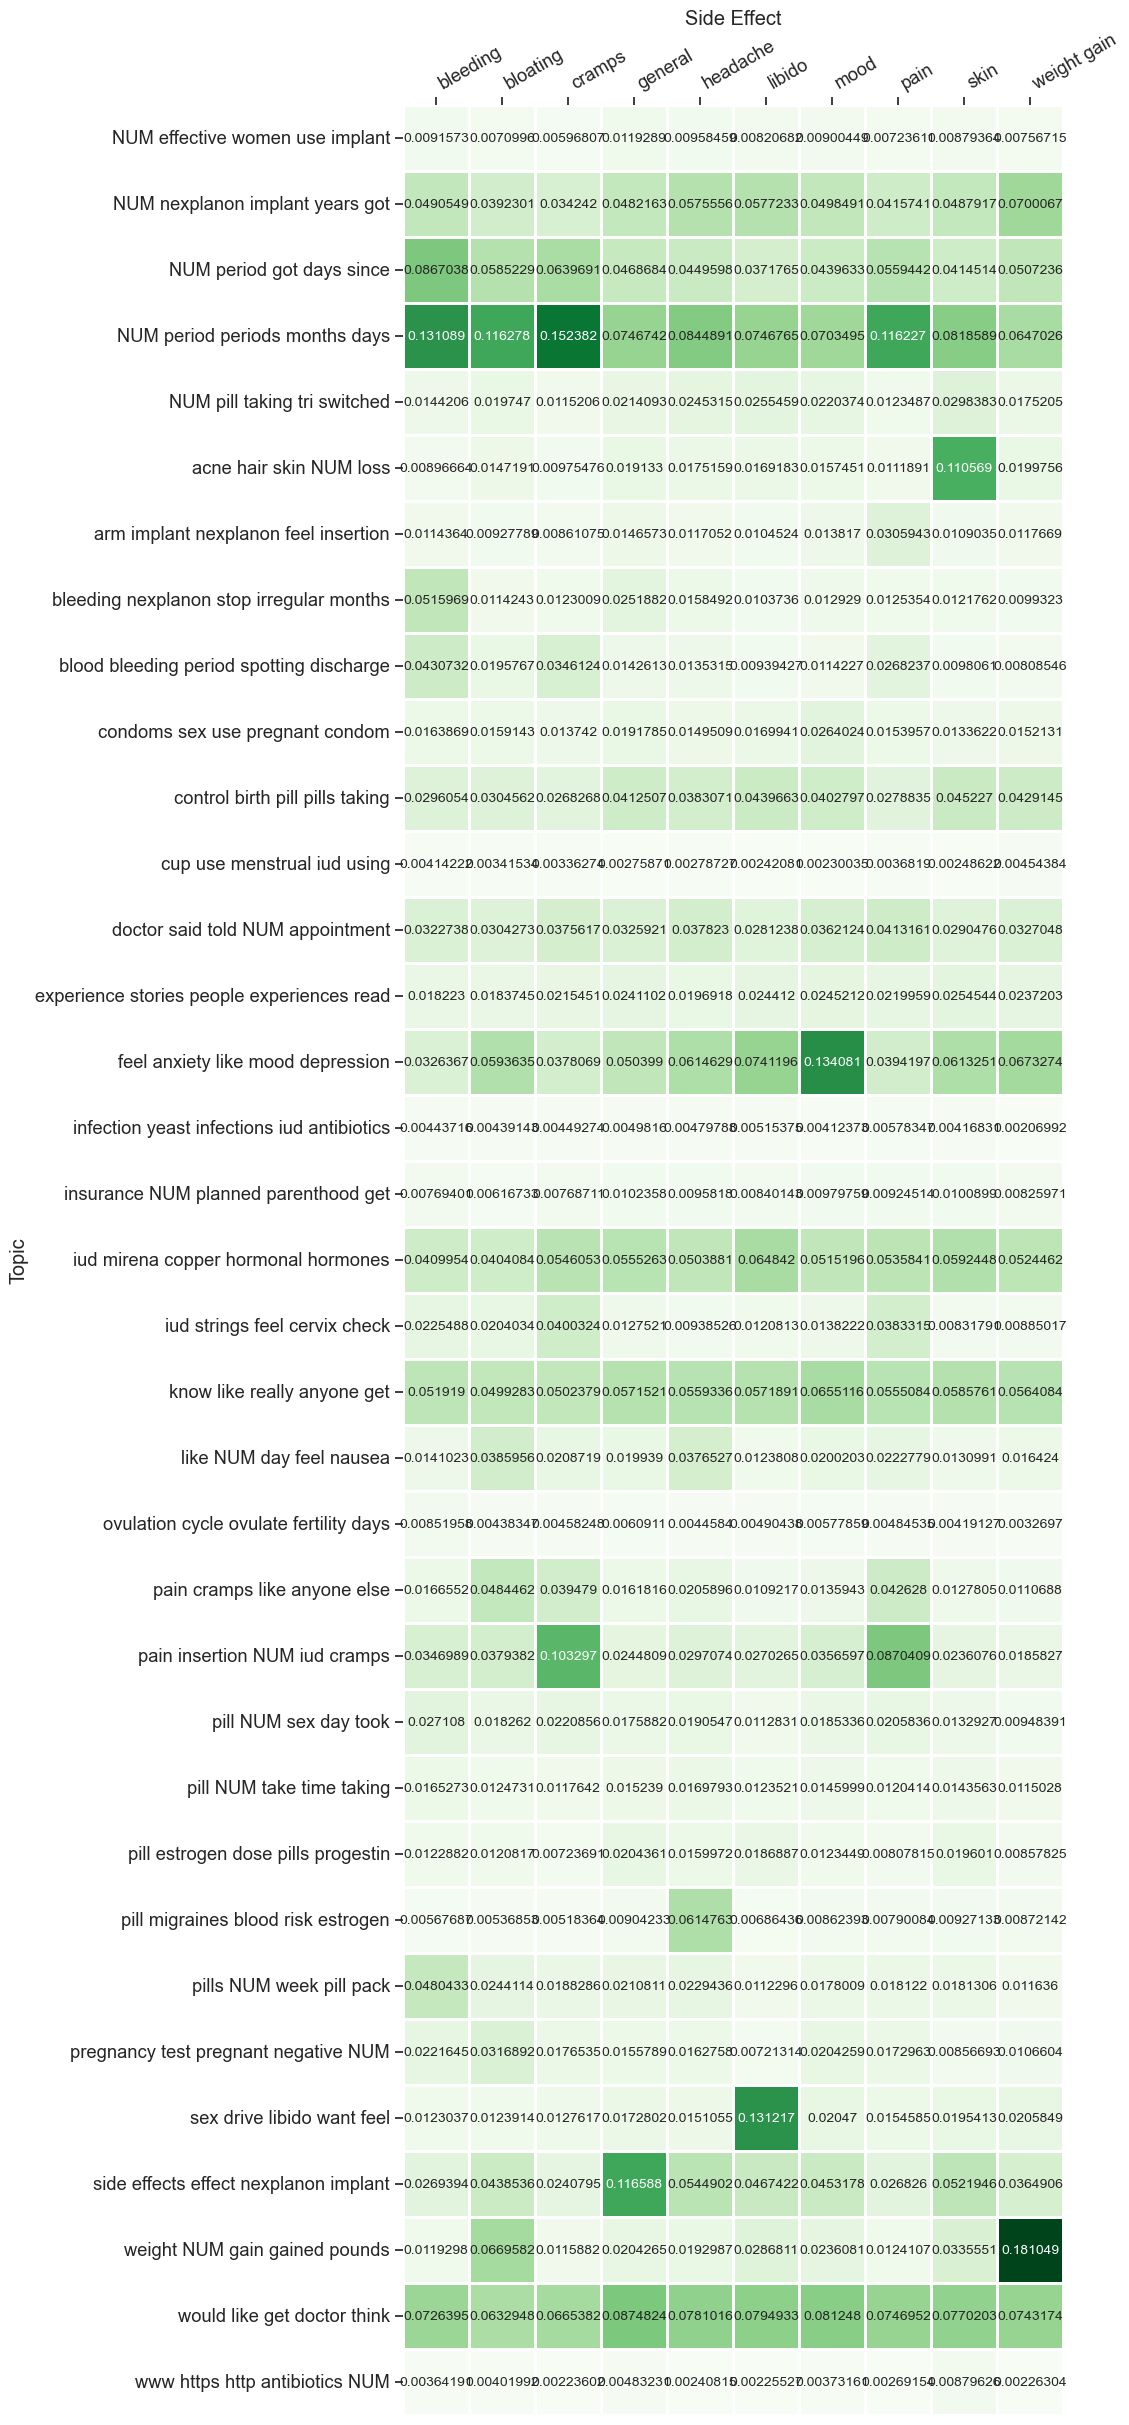

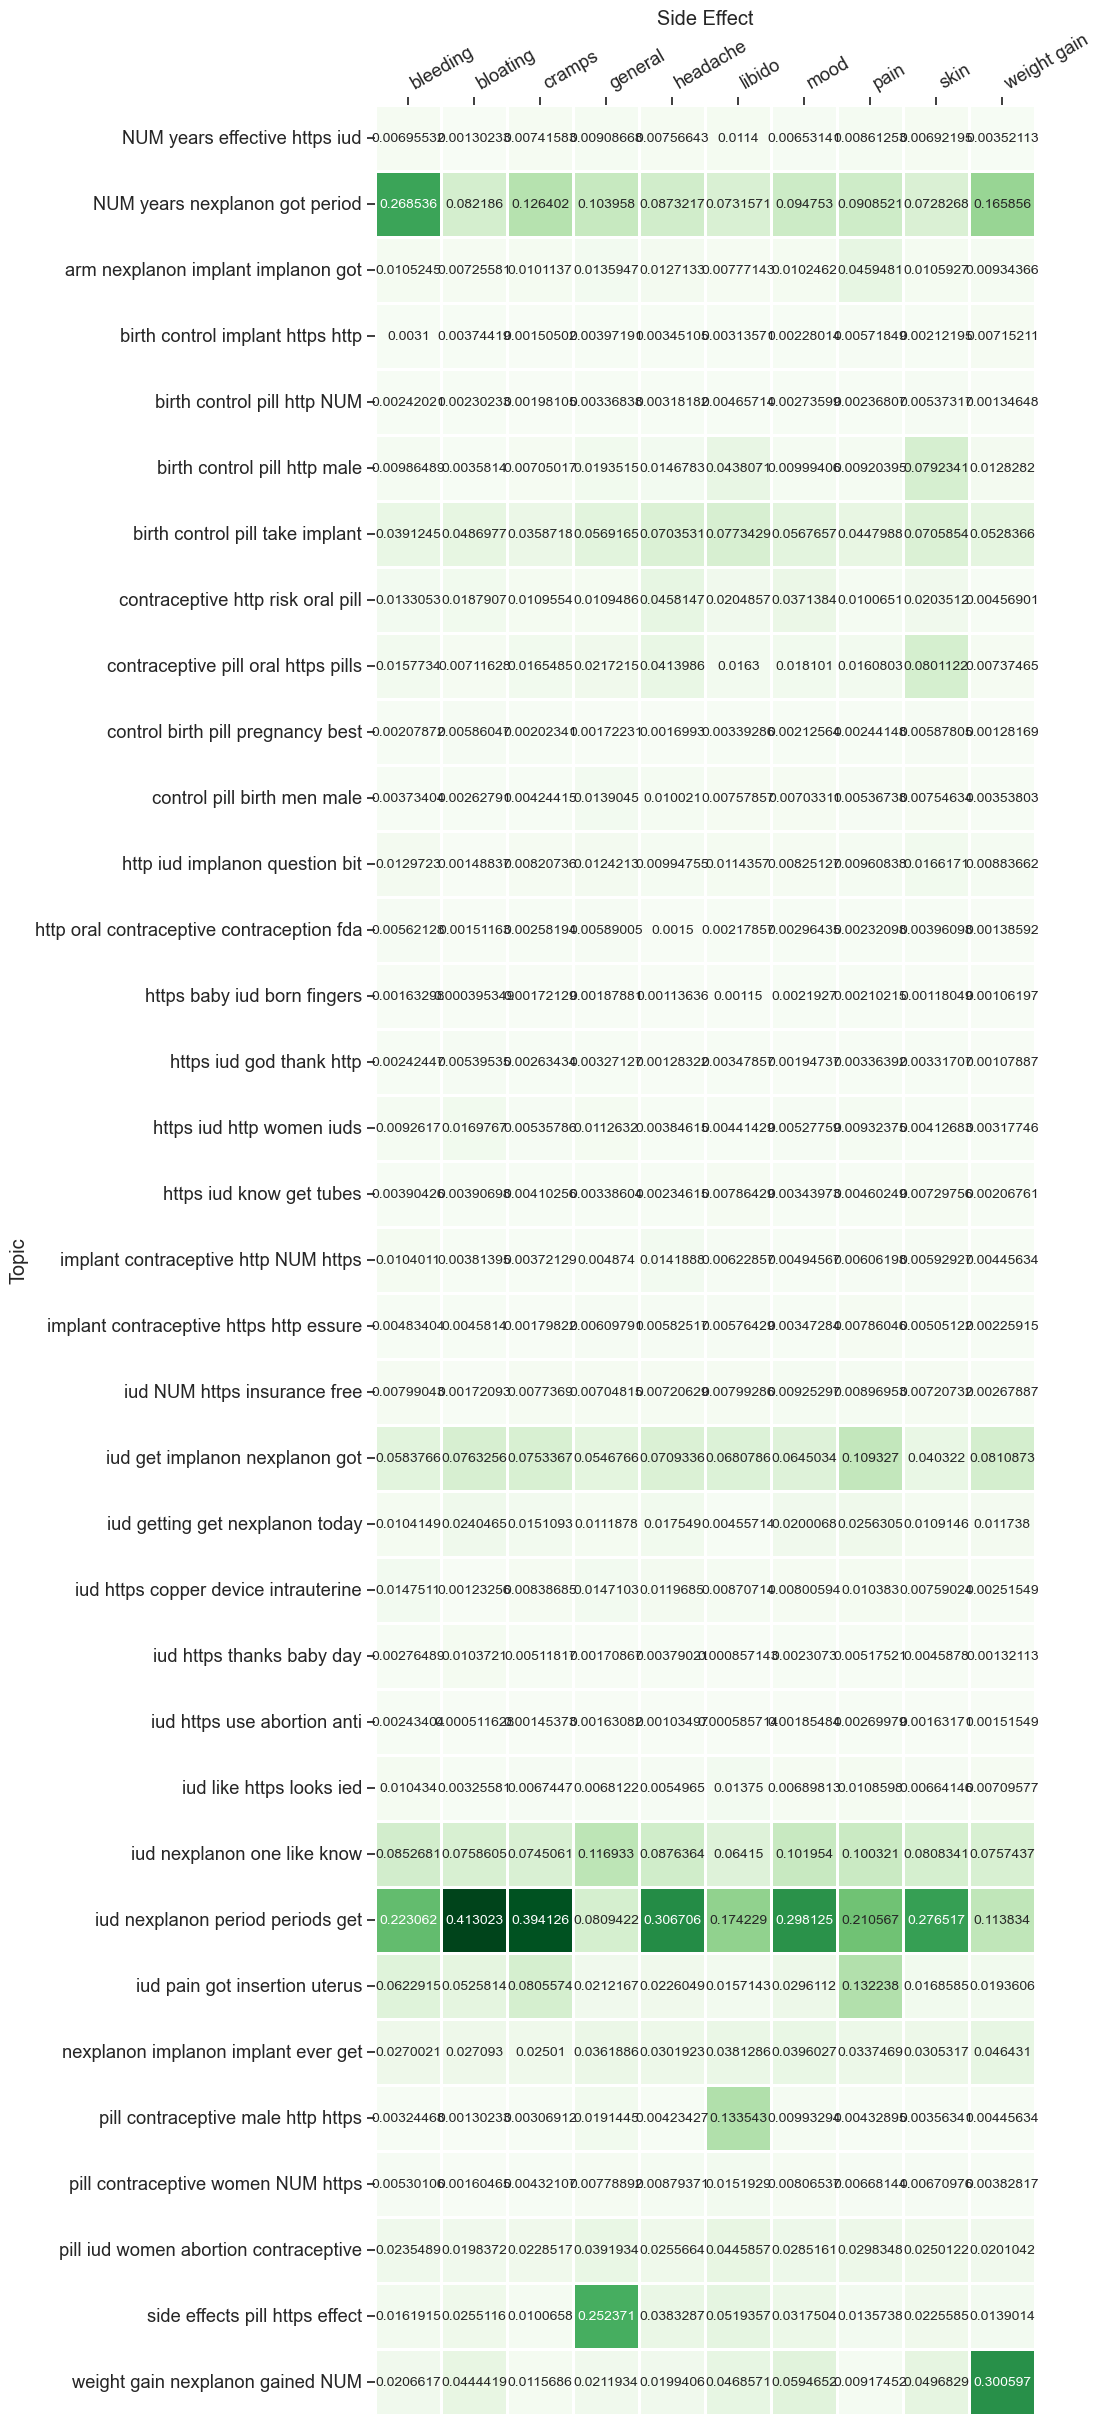

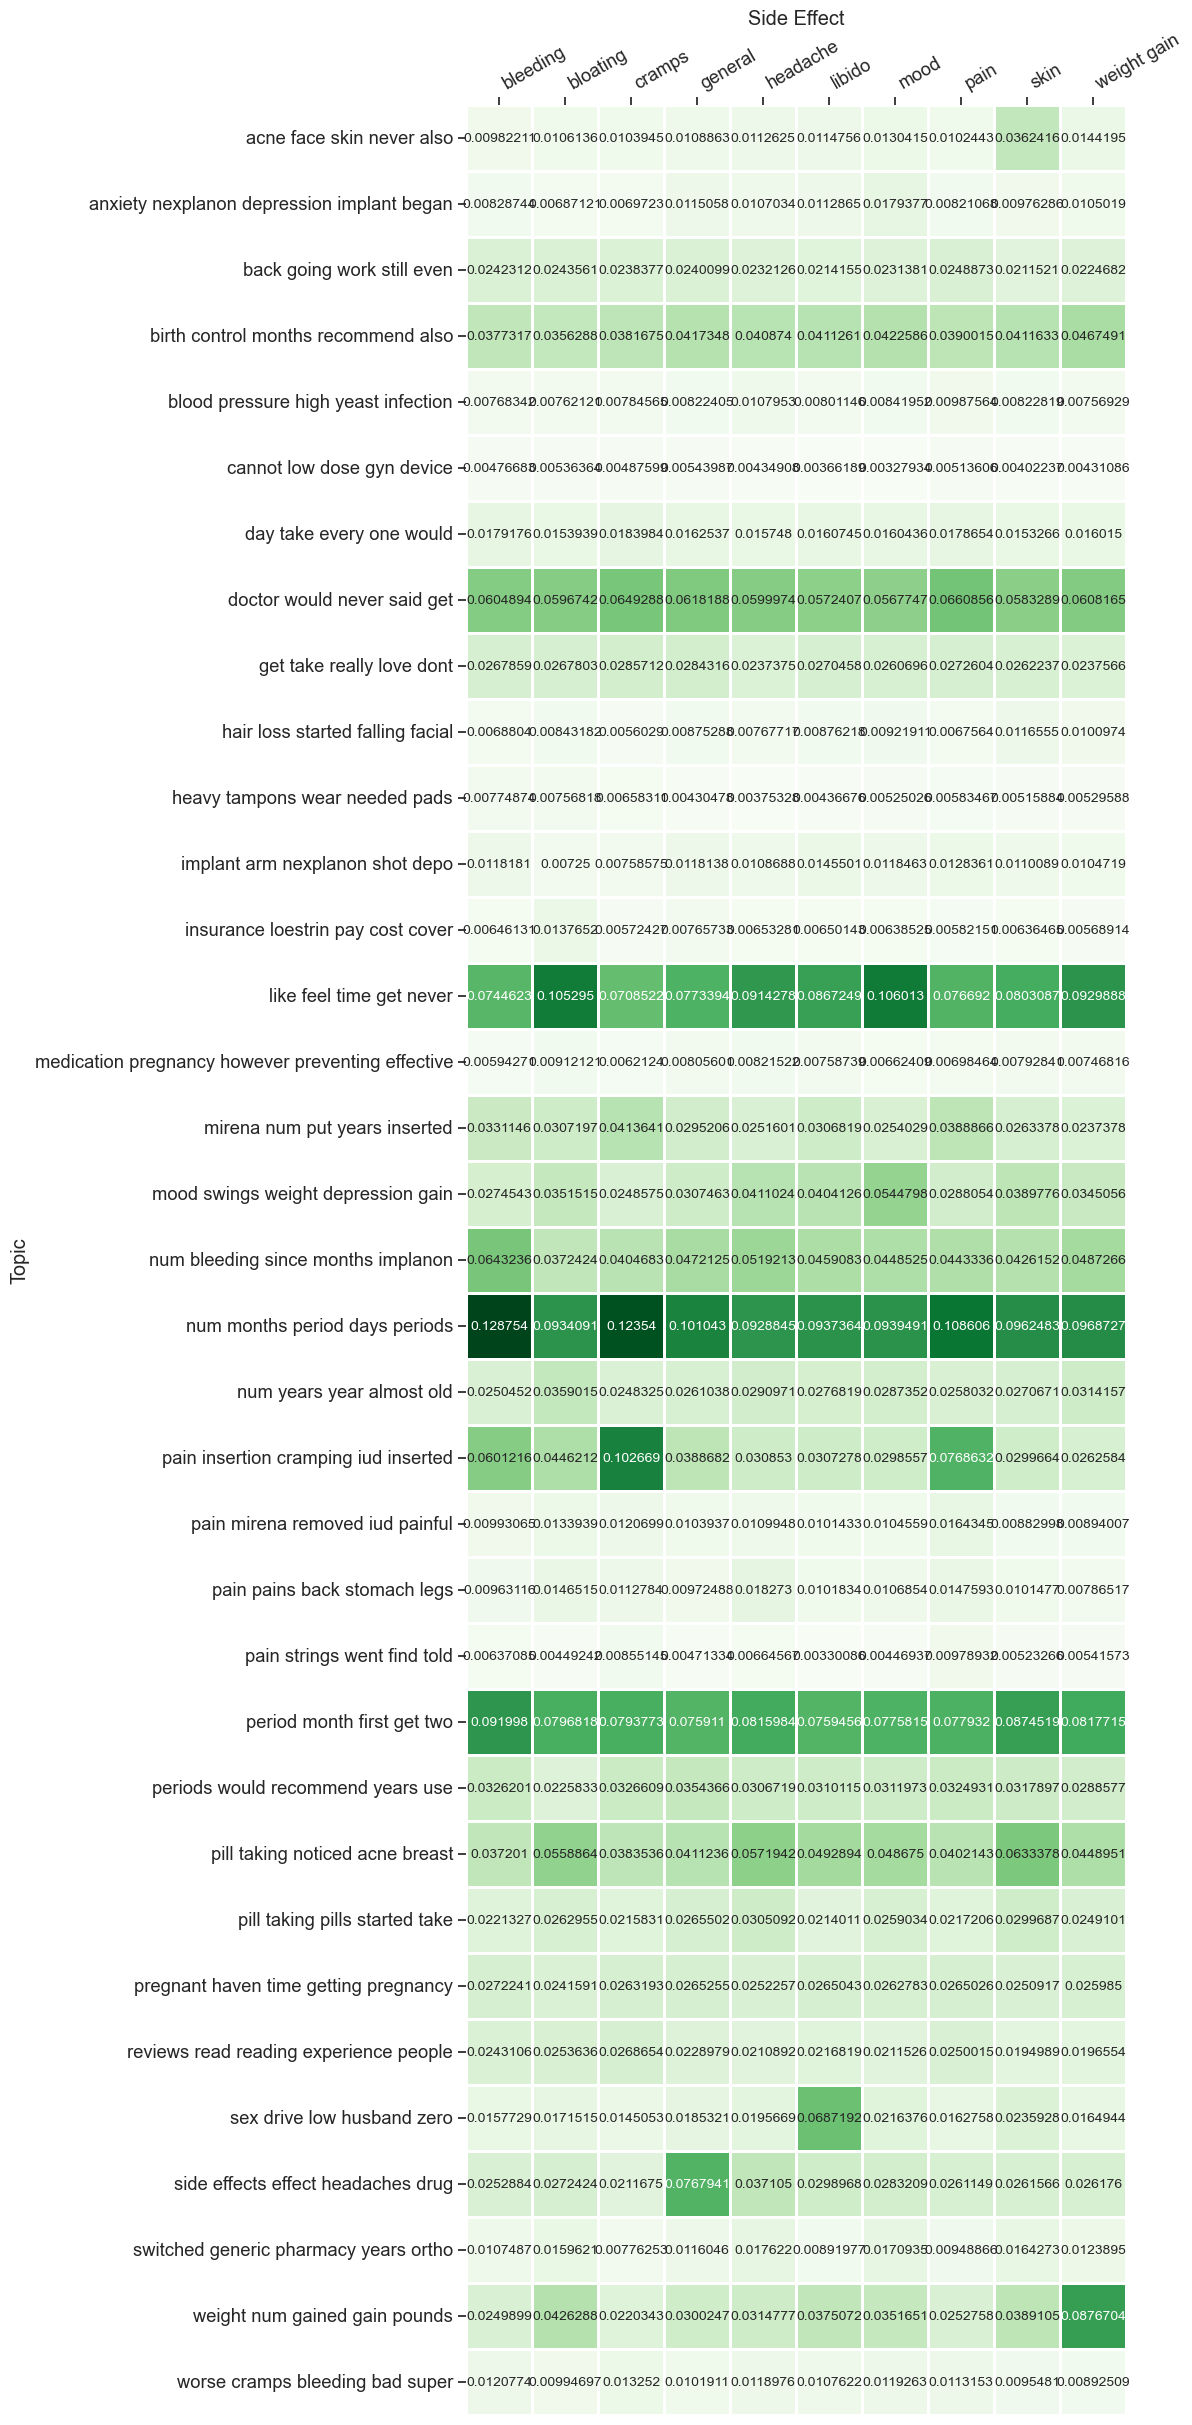

In [19]:
for _source, _side_effect_ids_dict in source_side_effect_ids_dict.items():

    dicts_to_plot = []
    for _side_effect, _ids in _side_effect_ids_dict.items():
        if _side_effect in ['bleeding', 'bloating', 'cramps', 'headache', 'libido', 'nauseua', 'skin', 'general', 'mood', 'pain', 'weight gain']:
            for _id in _ids:
                for _topic, _probability in enumerate(source_distributions_dict[_source][_id]):
                    dicts_to_plot.append({'Side Effect': _side_effect,
                                        'Topic Index': _topic,
                                        'Topic': ' '.join(source_topic_keys_dict[_source][_topic][:5]),
                                        'Probability': round(float(_probability), 3),
                                        'Source': _source})
    df_to_plot = pd.DataFrame(dicts_to_plot)

    df_wide = df_to_plot.pivot_table(index='Topic', 
                                    columns='Side Effect', 
                                    values='Probability')
    df_norm_col=(df_wide-df_wide.mean())/df_wide.std()
        
    plt.figure(figsize=(10,30))
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_wide, 
                     cmap='Greens', 
                     cbar=False, 
                     linewidths=1, 
                     annot=True, 
                     fmt='g', 
                     square=True, 
                     annot_kws={'fontsize':10})  
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    # plt.savefig(output_directory_path + '/plots/labeling/heatmap.topics_x_side_effects.percents.pdf', bbox_inches='tight')
    plt.show()

In [13]:
df_to_plot.sample(10)

,Side Effect,Topic Index,Topic,Probability,Source
328581,nausea,1,pill NUM sex day took,5.538126456665074E-4,reddit
197168,mood,13,blood bleeding period spotting discharge,0.0015729280978413938,reddit
1304734,bleeding,4,infection yeast infections iud antibiotics,0.0013521017320782705,reddit
763294,pain,14,pain cramps like anyone else,7.91139354468062E-4,reddit
1165814,bleeding,34,NUM period periods months days,0.4343536513331459\n,reddit
772708,pain,13,blood bleeding period spotting discharge,0.0025987818130296003,reddit
43061,mood,11,insurance NUM planned parenthood get,8.79370814072538E-4,reddit
35016,mood,16,side effects effect nexplanon implant,0.0262408845585413,reddit
928877,bleeding,12,weight NUM gain gained pounds,6.591340773565279E-4,reddit
888183,pain,23,NUM pill taking tri switched,8.823502788255996E-4,reddit


In [32]:
df_to_plot['Source'].value_counts()

reddit    2349200
Name: Source, dtype: int64